# Initialisation

In [ ]:
from Erdre_1 import Image, Dataset
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matching
import cv2
import copy

In [2]:
#Execute if needed
import pip
pip.main(["install", "openpyxl"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: openpyxl in c:\users\exill\anaconda3\envs\erdre\lib\site-packages (3.1.5)

Requirement already satisfied: et-xmlfile in c:\users\exill\anaconda3\envs\erdre\lib\site-packages (from openpyxl) (2.0.0)

0

# Loading the Data

Choisir l'année voulue

In [ ]:
année = "1999"

In [ ]:
db_path = 'database.xlsx'
input_dir = f'images/{année}'

DATA = Dataset(input_dir, db_path)
print("Done importing data")


Done importing data


# Preprocessing

Création d'un duplicat du dataset pour ne pas avoir à recharger les images en cas de problème.

In [4]:
PREPROCESSED_DATA=copy.deepcopy(DATA)
print(PREPROCESSED_DATA.names)

['1999_A00S01251_16', '1999_A00S01251_17']


Execution du preprocessing, choisir le seuil et le scaling (la définition) voulue

In [5]:
threshold = 1
scale =0.1
PREPROCESSED_DATA.preprocessing(border_threshold=threshold, homo_scale=scale)
print("Done preprocessing data")


PROCESSING...
Processing 1999_A00S01251_16
Scaling 1999_A00S01251_16
Done scaling
Rotating 1999_A00S01251_16
Done rotating
Cutting border from 1999_A00S01251_16
do the right thing
✅ Done processing
Done
Processing 1999_A00S01251_17
Scaling 1999_A00S01251_17
Done scaling
Rotating 1999_A00S01251_17
Done rotating
Cutting border from 1999_A00S01251_17
do the right thing
✅ Done processing
Done
Done preprocessing data


Validation du preprocessing dans le Dataset principal

In [6]:
DATA=copy.deepcopy(PREPROCESSED_DATA)

# Matching

Matching des images

In [7]:
H, mask, matches = DATA.match()
print("Done matching images")


Done matching images


In [ ]:
#Temp
print(H)

{('1999_A00S01251_16', '1999_A00S01251_17'): array([[ 1.16322625e+00, -8.83745481e-01,  2.61291987e+02],
       [ 6.63480600e-01, -3.83999830e-01,  5.38568558e+01],
       [ 2.77356719e-03, -2.77356719e-03,  1.00000000e+00]])}


In [ ]:
#Temp
H1 = H[(DATA.images[0].name,DATA.images[1].name)]
"""r1 = H1[:, 0]
r2 = H1[:, 1]

# Normalize them to get orthonormal basis
r1 = r1 / np.linalg.norm(r1)
r2 = r2 / np.linalg.norm(r2)
r3 = np.cross(r1[:3], r2[:3])  # Compute third column using cross product

# Rotation matrix
R = np.column_stack((r1[:3], r2[:3], r3))

print("Rotation Matrix:\n", R)

# Convert rotation matrix to Euler angles
from scipy.spatial.transform import Rotation as Rot
euler_angles = Rot.from_matrix(R).as_euler('xyz', degrees=True)

print("Euler Angles (X, Y, Z) in Degrees:", euler_angles)"""

r11, r12 = H1[0, 0], H1[0, 1]
r21, r22 = H1[1, 0], H1[1, 1]

# Compute rotation angle
theta = np.arctan2(r21, r11)  # Radians
angle = np.degrees(theta)  # Degrees

print(f"Rotation Angle: {angle:.2f}°")


Rotation Angle: 29.70°


Calcul des angles de rotation pour chaque couple d'images

In [10]:
names = DATA.names
n = len(names)
ANGLES = {}
# Loop through each pair of images and calculate the rotation angle
for i in range(n):
    for j in range(i + 1, n):
        image_1_name = names[i]
        image_2_name = names[j]
        # Calculate the rotation angle between the pair of images
        ANGLES[(image_1_name, image_2_name)] = matching.extract_rotation_angle(H[(image_1_name, image_2_name)])
        # Since the rotation between (image_1_name, image_2_name) and (image_2_name, image_1_name) is the same
        ANGLES[(image_2_name, image_1_name)] = ANGLES[(image_1_name, image_2_name)]

Impression de la matrice de validation du matching (Valide si angle ~= 0)

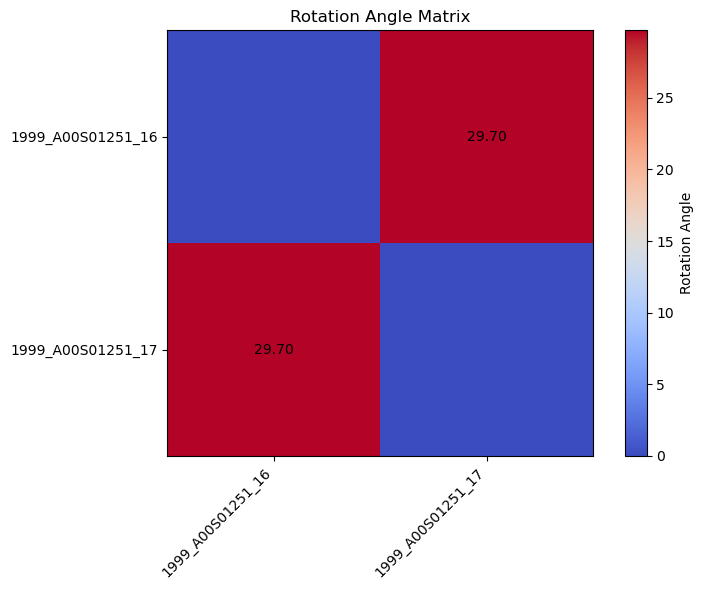

In [11]:
matching.matrice_angles(ANGLES, DATA.names)

# Stitching

Enregistrement des dimensions des images

In [12]:
#Storing image sizes
h = {img.name: img.image.shape[0] for img in DATA.images}
w = {img.name: img.image.shape[1] for img in DATA.images}

Création d'un dictionnaire pour enregistrer les postions relatives des images par rapport à l'image mère (ici la première image chargée)

In [13]:
# Initialize placement tracking
placed_images = {DATA.images[0].name: (0, 0)}  # Core image at (0,0)
unmatched_images = {img.name: "unmatched" for img in DATA.images}  
unmatched_images[DATA.images[0].name] = "matched" # All images except the core

In [14]:
last_placed_image = DATA.images[0].name

Création d'une toile pour y imprimer les images

In [15]:
# Initialize bounding box
min_x, min_y = 0, 0
max_x, max_y = w[DATA.images[0].name], h[DATA.images[0].name]

# Create a canvas big enough to fit both images
canvas = np.zeros((h[DATA.images[0].name], w[DATA.images[0].name], 3) , dtype=np.uint8)
canvas[0:h[DATA.images[0].name],0:w[DATA.images[0].name]] = DATA.images[0].image

Evaluation des images et enregistrement des translations entre les images

In [16]:
while any(status == "unmatched" for status in unmatched_images.values()):
    newly_matched = []

    # Loop through the unmatched images
    for img_name in list(unmatched_images):
        if unmatched_images[img_name] == "matched":
            continue  # Skip if the image is already matched

        matched = False
        
        if last_placed_image is not None:  # Ensure there's a last placed image to match against
            ref_name = last_placed_image  # We now only match with the last placed image

            # Proceed with matching logic
            if abs(ANGLES[(img_name, ref_name)]) <= 100:  # Accept if rotation is small
                if (img_name, ref_name) in H:
                    tx, ty = -H[(img_name, ref_name)][0, 2], -H[(img_name, ref_name)][1, 2]
                else:
                    tx, ty = -H[(ref_name, img_name)][0, 2], -H[(ref_name, img_name)][1, 2]

                ref_x, ref_y = placed_images[ref_name]

                # Compute new image's position
                new_x = ref_x + int(round(tx))
                new_y = ref_y + int(round(ty))

                # Update bounding box (if necessary)
                min_x = min(min_x, new_x)
                min_y = min(min_y, new_y)
                max_x = max(max_x, new_x + w[img_name])
                max_y = max(max_y, new_y + h[img_name])

                # Store position of the newly matched image
                placed_images[img_name] = (new_x, new_y)
                unmatched_images[img_name] = "matched"  # Update the status to matched
                newly_matched.append(img_name)
                matched = True
                print(f"matching {img_name} with {ref_name}")
                
                # Update last_placed_image to the newly placed image
                last_placed_image = img_name
                break  # Stop checking other references for this image
        
        
        """for ref_name in placed_images:

            
            if abs(ANGLES[(img_name,ref_name)]) <= 5:  # Accept if rotation is small
                if (img_name,ref_name) in H:
                    tx, ty = -H[(img_name,ref_name)][0, 2], -H[(img_name,ref_name)][1, 2]
                else:
                    tx, ty = -H[(ref_name,img_name)][0, 2], -H[(ref_name,img_name)][1, 2]
                
                ref_x, ref_y = placed_images[ref_name]

                # Compute new image's position
                new_x = ref_x + int(round(tx))
                new_y = ref_y + int(round(ty))

                # Update bounding box
                min_x = min(min_x, new_x)
                min_y = min(min_y, new_y)
                max_x = max(max_x, new_x + w[img_name])
                max_y = max(max_y, new_y + h[img_name])

                # Store position of the newly matched image
                placed_images[img_name] = (new_x, new_y)
                unmatched_images[img_name] = "matched"  # Update the status to matched
                newly_matched.append(img_name)
                matched = True
                print("matching " + img_name + " with " + ref_name)
                break  # Stop checking other references"""

        if not matched:
            # If no match was found for this image, it stays unmatched (no need to change)
            pass

    if not newly_matched:
        print("No new matches found. Exiting loop.")
        break  # Stop if no new images were placed


matching 1999_A00S01251_17 with 1999_A00S01251_16


Ajustement de toutes les positions dans le cas d'images se plaçant avant l'image mère en x ou y (qui résulte en une position négative) 

In [17]:
# Adjust for negative translations
shift_x, shift_y = -min_x, -min_y
new_canvas = np.zeros((max_y - min_y, max_x - min_x, 3), dtype=np.uint8)

# Shift all placed images
for img_idx, (old_x, old_y) in placed_images.items():
    placed_images[img_idx] = (old_x + shift_x, old_y + shift_y)

# Copy old canvas onto new
new_canvas[shift_y:shift_y + canvas.shape[0], shift_x:shift_x + canvas.shape[1]] = canvas
canvas = new_canvas

Impression des images sur la toile

In [18]:
# Place all images
for image_name, (x_offset, y_offset) in placed_images.items():
    canvas[y_offset:y_offset + h[image_name], x_offset:x_offset + w[image_name]] = DATA.get_image(image_name)

Rendu JPG de la toile

In [19]:
cv2.imwrite(f"stitched_{année}.jpg", canvas)

True